In [1]:
import time
import copy

import numpy
from sklearn import datasets
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
def knn(dataset, query, k):
    sample_num = dataset.shape[0]
    sqr_diff = ((numpy.tile(query, (sample_num, 1)) - dataset) ** 2)
    dist = numpy.sum(sqr_diff, axis=1)

    sorted_dist = numpy.argsort(dist)
    if k > len(sorted_dist):
        k = len(sorted_dist)

    return sorted_dist[0:k]

def build_graph(matrix, k=None):
    sample_num = matrix.shape[0]
    affinity_matrix = numpy.zeros((sample_num, sample_num),numpy.float32)
    
    if k == None:
        raise ValueError("Should Input a K for KNN")
    for i in range(sample_num):
        k_neighbors = knn(matrix, matrix[i,:],k)
        affinity_matrix[i][k_neighbors]=1.0 / k
    return affinity_matrix

def label_propagation(labeled_matrix, unlabeled_matrix, labels, k, max_iter, tol=1e-4):
    t0 = time.time()

    labeled_sample_num = labeled_matrix.shape[0]
    unlabeled_sample_num = unlabeled_matrix.shape[0]
    sample_num = labeled_sample_num + unlabeled_sample_num

    labels_list = numpy.unique(labels)
    labels_num = len(labels_list)
    matrix = numpy.vstack((labeled_matrix, unlabeled_matrix))

    clamp_data_label = numpy.zeros((labeled_sample_num, labels_num),numpy.float32)
    for i in range(labeled_sample_num):
        clamp_data_label[i][labels[i]] = 1.0
    
    # Build the label_function F
    label_function = numpy.zeros((sample_num, labels_num), numpy.float32)
    label_function[0: labeled_sample_num] = clamp_data_label
    label_function[labeled_sample_num: sample_num] = -1

    # Build Graph with KNN from iris dataset
    affinity_matrix = build_graph(matrix, k)
    
    t1 = time.time()
    print("Build Graph Time:", t1 -t0)

    iter_time = 0
    pre_label_function = numpy.zeros((sample_num, labels_num),numpy.float32)
    changed = numpy.abs(pre_label_function - label_function).sum()
    while iter_time < max_iter and changed > tol:
        print("Iteration: %d/%d, Changed: %f" % (iter_time, max_iter, changed))
        pre_label_function = label_function
        iter_time += 1

        # Iteration: F = PF
        label_function = numpy.dot(affinity_matrix, label_function)
        label_function[0: labeled_sample_num] = clamp_data_label

        # Check Convergence
        changed = numpy.abs(pre_label_function - label_function).sum()

    unlabel_data_labels = numpy.zeros(unlabeled_sample_num)
    for i in range(unlabeled_sample_num):
        unlabel_data_labels[i] = numpy.argmax(label_function[i + labeled_sample_num])
    
    t2 = time.time()
    print("Label Propagation time:", t2 -t1)
    return unlabel_data_labels


In [3]:
def diagram(data, label):
    for i in range(len(data)):
            if label[i] == 0:
                plt.scatter(data[i][0], data[i][1], alpha=0.8, c='r')
            if label[i] == 1:
                plt.scatter(data[i][0], data[i][1], alpha=0.8, c='g')
            if label[i] == 2:
                plt.scatter(data[i][0], data[i][1], alpha=0.8, c='b')
            if label[i] == -1:
                plt.scatter(data[i][0], data[i][1], alpha=0.8, c='c')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

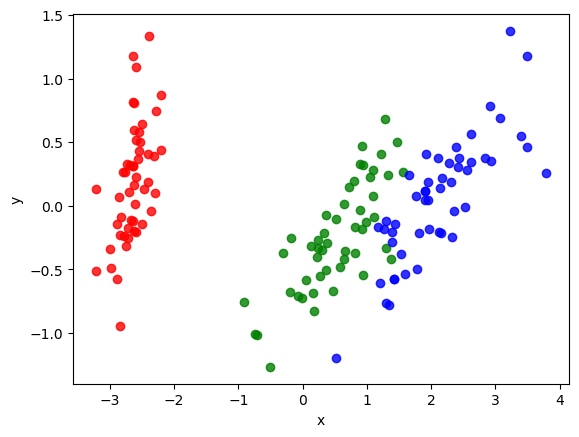

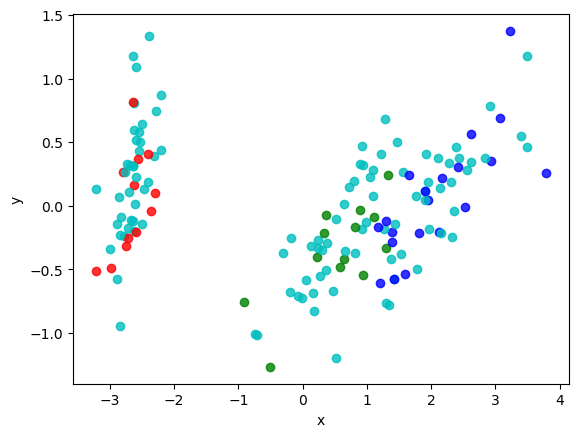

Unlabeled Dataset: (105,)
Build Graph Time: 0.008716106414794922
Iteration: 0/400, Changed: 360.000000
Iteration: 1/400, Changed: 114.399986
Iteration: 2/400, Changed: 77.000008
Iteration: 3/400, Changed: 55.372002
Iteration: 4/400, Changed: 40.926399
Iteration: 5/400, Changed: 30.780241
Iteration: 6/400, Changed: 23.381832
Iteration: 7/400, Changed: 17.867626
Iteration: 8/400, Changed: 13.705235
Iteration: 9/400, Changed: 10.539791
Iteration: 10/400, Changed: 8.121326
Iteration: 11/400, Changed: 6.267773
Iteration: 12/400, Changed: 4.843884
Iteration: 13/400, Changed: 3.748023
Iteration: 14/400, Changed: 2.903289
Iteration: 15/400, Changed: 2.251218
Iteration: 16/400, Changed: 1.747232
Iteration: 17/400, Changed: 1.357238
Iteration: 18/400, Changed: 1.055140
Iteration: 19/400, Changed: 0.820892
Iteration: 20/400, Changed: 0.639086
Iteration: 21/400, Changed: 0.497870
Iteration: 22/400, Changed: 0.388092
Iteration: 23/400, Changed: 0.302688
Iteration: 24/400, Changed: 0.236206
Iteratio

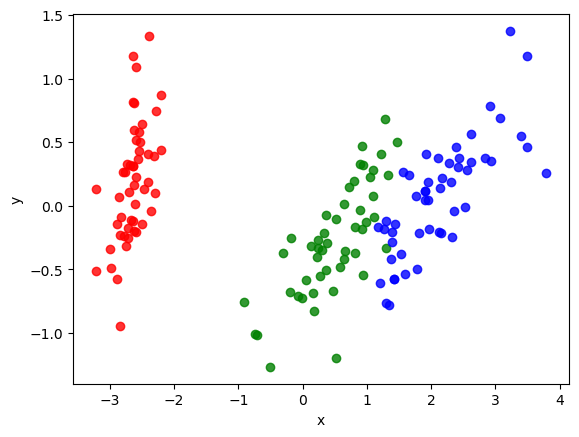

Accuracy: 0.9714285714285714


In [4]:
# Init the iris dataset use PCA
k = 10
pca = PCA(n_components=2)
iris = datasets.load_iris()
rate = 0.7
label = numpy.copy(iris.target)

unlabel_index = numpy.random.rand(len(label))
unlabel_index = unlabel_index < rate
label_index = [~x for x in unlabel_index]

train_data = iris.data[label_index]
train_label = label[label_index]
test_data = iris.data[unlabel_index]
test_label = label[unlabel_index]

pca.fit(iris.data)
plotx = pca.transform(iris.data)
diagram(plotx, label)
tmp_label = copy.deepcopy(label)
tmp_label[unlabel_index] = -1
diagram(plotx, tmp_label)
print("Unlabeled Dataset:", test_label.shape)

# Start Up Label_Propagation
pre_labels = label_propagation(train_data, test_data, train_label, k, max_iter=400)
ultradata = numpy.concatenate((train_data, test_data),axis=0)
ultralabel = numpy.concatenate((train_label,pre_labels),axis=0)
ultradata = pca.transform(ultradata)
diagram(ultradata, ultralabel)

# Check Accuracy, Use sk-learn
print("Accuracy:", accuracy_score(test_label, pre_labels))